# Grid and Feature Contribution

This document shows the procedure of grid search and feature contribution investigation. 

In [252]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sv = survey('data/survey2/')

In [3]:
sv.num_processor()

In [4]:
df = sv.fin_data

In [6]:
dfc = df.copy()
dfc['educom'] = (dfc.paeduc+dfc.maeduc+dfc.speduc)/3        
dfc.drop(['paeduc','maeduc','speduc'], axis =1, inplace=True)
y = dfc.pop('employed').values
X = dfc.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

### 1. Fit random forest model

In [8]:
rf = RandomForestClassifier(n_jobs=-1,random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Take first 30 important features to model

In [9]:
f30 = rf.feature_importances_.argsort()[::-1][:30]
rf_redu = RandomForestClassifier(n_jobs=-1,random_state=0)
slct=dfc.columns[f30]   #selected features
X = dfc[slct].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [11]:
rf_redu.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## 2. Grid search

In [44]:
#1st round
# rf_grid = {'max_depth': [3, None], 
#                       'max_features': ['sqrt', 'log2', None],
#                       'min_samples_split': [1, 2, 4],
#                       'min_samples_leaf': [1, 2, 4],
#                       'bootstrap': [True, False],
#                       'n_estimators': [10, 20, 40],
#                       'random_state': [1]}

#2nd
rf_grid = {'max_depth': [None], 
           'criterion':['gini','entropy'],
                      'max_features': ['log2', None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [True, False],
                      'n_estimators': [30, 40,80],
                      'random_state': [1]}

#3rd 
rf_grid = {'max_depth': [None], 
           'criterion':['gini'],
                      'max_features': ['log2',None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [60,80,100],
                      'random_state': [1]}
#last round
rf_grid = {'max_depth': [None], 
           'criterion':['gini'],
                      'max_features': ['log2',None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [230,250,300],
                      'random_state': [1]}

In [45]:
rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             rf_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')

In [46]:
rf_gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   29.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [230, 250, 300], 'min_samples_split': [1], 'random_state': [1], 'criterion': ['gini'], 'max_features': ['log2', None], 'bootstrap': [False], 'max_depth': [None], 'min_samples_leaf': [2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc',
       verbose=True)

In [47]:
rf_gridsearch.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 1,
 'n_estimators': 300,
 'random_state': 1}

In [49]:
best_rf = rf_gridsearch.best_estimator_

roc_auc_score : 0.818305210155


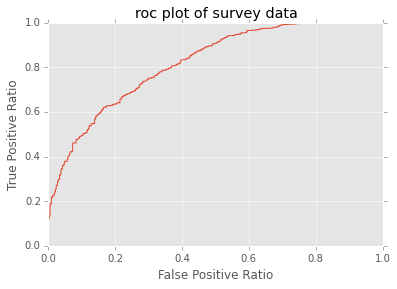

In [51]:
plot_roc(best_rf,X_test,y_test)

### 3.  Tree Interpreter and Feature Contribution

In [ ]:
prediction, bias, contributions = ti.predict(best_rf, X_test)

#### make feature contribution data frame

In [283]:
fc_df = pd.DataFrame(contributions[:,:,1], columns=slct)

In [284]:
fc_df['predict'] = best_rf.predict(X_test)    # predicted result

In [285]:
fc_df['employed'] = y_test                   # true result

In [286]:
fc_df['correct'] = fc_df.predict == fc_df.employed      # check if the prediction is correct

In [287]:
fc_df.drop('predict',axis =1, inplace=True)               #subset correct instances

## Clustering Feature Contribution Matrix

* pca
* kmeans on principle components

### PCA

In [323]:
fc_pca = fc_df.drop(['employed','correct'],axis =1)       #only pass feature columns to pca

In [289]:
pca = PCA(n_components= 10)
pca.fit(fc_pca.values)

PCA(copy=True, n_components=10, whiten=False)

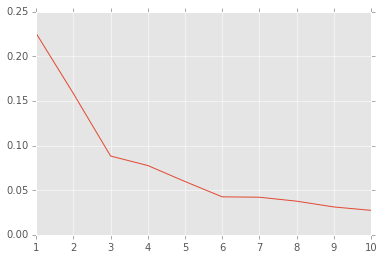

In [290]:
plt.plot(range(1,11),pca.explained_variance_ratio_)

** Three principle components will be fine **

In [325]:
pca = PCA(n_components=3)
fc_pca = pca.fit_transform(fc_pca.values)

### Kmeans

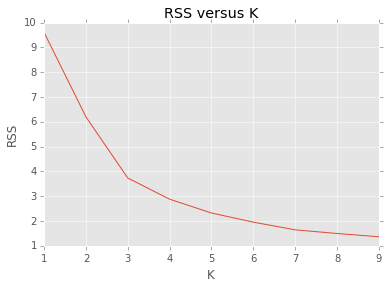

In [326]:
plot_kmean(fc_pca,10)

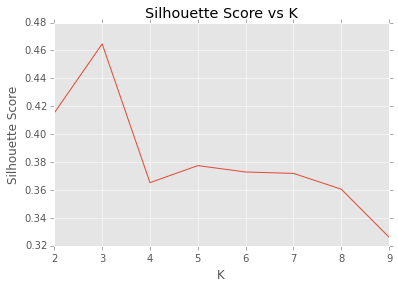

In [327]:
plot_silhouette(fc_pca, 10)

('For n_clusters =', 3, 'The average silhouette_score is :', 0.46521484253716905)


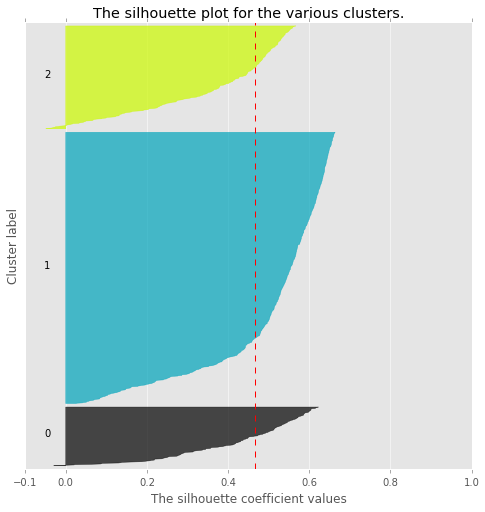

In [328]:
cluster_plot(fc_pca,3)

** Three clusters will be fine**

In [386]:
km = KMeans(n_clusters= 3)
km.fit(fc_pca)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [387]:
km.labels_

array([1, 1, 2, ..., 1, 0, 2], dtype=int32)

In [388]:
fc_df['cluster'] = km.labels_

## Group feature contribution matrix by cluster id

In [389]:
def max_abs(v):
    return max(abs(v))

fc_df.groupby('cluster').agg([np.mean, max_abs, np.std]).T

cluster                     0            1            2
coninc   mean      -0.0678244     0.032144   -0.0292512
         max_abs     0.175683     0.119609     0.161206
         std        0.0342012    0.0228691    0.0609985
age      mean     -0.00791387   0.00274242  -0.00171767
         max_abs     0.151892     0.186369    0.0760458
         std        0.0313777    0.0264785     0.028573
educom   mean     -0.00367282 -0.000187733  -0.00469164
         max_abs     0.157037     0.168044    0.0520578
         std        0.0281173    0.0270807    0.0152616
degree   mean        0.025556    0.0175088    -0.122316
         max_abs     0.110804    0.0910336     0.176064
         std        0.0175884    0.0143265    0.0195184
sphrs1   mean     0.000336066  -0.00263207   0.00193583
         max_abs     0.113086     0.179839    0.0492054
         std        0.0172102    0.0310552    0.0117554
partyid  mean    -0.000806001  0.000447565 -0.000563196
         max_abs     0.111773    0.0932283    0.0463949
         std        0.0155948    0.0140957    0.0102503
agekdbrn mean     -0.00316526   0.00150882  -0.00708701
         max_abs    0.0639196    0.0605912    0.0702904
         std         0.020562    0.0148418    0.0156605
class_   mean      -0.0126399   0.00331849  -0.00329847
         max_abs      0.14648     0.123616     0.100077
         std         0.050896    0.0246601    0.0385891
dwelling mean     -0.00145018 -0.000347825 -0.000526779
         max_abs    0.0593772     0.121962    0.0632611
         std        0.0138436    0.0125141    0.0135401
polviews mean     -0.00354245   0.00205056  -0.00185383
         max_abs    0.0787063     0.101109     0.042202
         std        0.0180568    0.0131027    0.0143291
...                       ...          ...          ...
natroad  mean     -0.00279954  0.000477758  -0.00131353
         max_abs    0.0886006     0.032921    0.0645758
         std        0.0120836   0.00722224    0.0102251
fechld   mean     -0.00209006    0.0017948  -0.00051546
         max_abs    0.0789947     0.110124    0.0597555
         std        0.0208179    0.0224656    0.0141526
helpoth  mean     -0.00150512  0.000562746     0.000994
         max_abs    0.0707782    0.0709016    0.0538471
         std       0.00907535   0.00843138    0.0104328
parsol   mean     -0.00252975  0.000575583 -0.000779246
         max_abs    0.0546431    0.0623145    0.0352899
         std        0.0116114   0.00946843    0.0107236
chldidel mean      -0.0014928   0.00099291  -0.00307842
         max_abs    0.0648203    0.0609397    0.0587859
         std        0.0130283    0.0135615    0.0106522
workhard mean    -0.000856762  0.000654263  -0.00053763
         max_abs      0.07284    0.0490836    0.0459969
         std        0.0117517     0.008147   0.00939058
mawrkgrw mean     -0.00227269  0.000109342  -0.00102558
         max_abs    0.0650753      0.05481    0.0340096
         std        0.0130874    0.0118969   0.00808428
meovrwrk mean     -0.00185824 -0.000268989 -0.000519502
         max_abs    0.0499894    0.0559554    0.0317791
         std       0.00884867   0.00830982   0.00864207
employed mean        0.518634     0.729988     0.412088
         max_abs         True         True         True
         std          0.50043     0.444231     0.493569
correct  mean        0.723602     0.782557     0.725275
         max_abs         True         True         True
         std         0.447912     0.412753     0.447607

[96 rows x 3 columns]

In [345]:
(fc_df.cluster == 5).sum()

116

In [370]:
fc_pca

array([[-0.06012309,  0.00086694,  0.04642241],
       [ 0.00436181, -0.01727396, -0.04863599],
       [ 0.13105441,  0.09862601,  0.01602734],
       ..., 
       [-0.03183517, -0.0116922 ,  0.00670359],
       [ 0.01833089, -0.0727856 , -0.00126729],
       [ 0.13974817,  0.06555088,  0.00876117]])

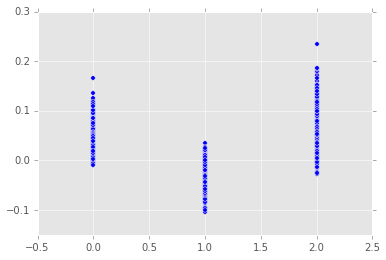

In [390]:
plt.scatter(km.labels_, fc_pca[:, 0])

In [381]:
fc_pca

array([[-0.06012309,  0.00086694,  0.04642241],
       [ 0.00436181, -0.01727396, -0.04863599],
       [ 0.13105441,  0.09862601,  0.01602734],
       ..., 
       [-0.03183517, -0.0116922 ,  0.00670359],
       [ 0.01833089, -0.0727856 , -0.00126729],
       [ 0.13974817,  0.06555088,  0.00876117]])